# Navigation

---

Congratulations for completing the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893)!  In this notebook, you will learn how to control an agent in a more challenging environment, where it can learn directly from raw pixels!  **Note that this exercise is optional!**

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/VisualBanana.app"`
- **Windows** (x86): `"path/to/VisualBanana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/VisualBanana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/VisualBanana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/VisualBanana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/VisualBanana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/VisualBanana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `VisualBanana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="VisualBanana.app")
```

In [2]:
env = UnityEnvironment(file_name="VisualBanana_Linux/Banana.x86_64")
# env = UnityEnvironment(file_name="VisualBanana.app")



INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The environment state is an array of raw pixels with shape `(1, 84, 84, 3)`.  *Note that this code differs from the notebook for the project, where we are grabbing **`visual_observations`** (the raw pixels) instead of **`vector_observations`**.* A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

Number of agents: 1
Number of actions: 4
States look like:


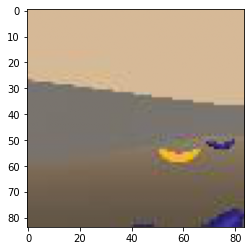

States have shape: (1, 84, 84, 3)


In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.visual_observations[0]
print('States look like:')
plt.imshow(np.squeeze(state))
plt.show()
state_size = state.shape
print('States have shape:', state.shape)

image.shape (84, 84, 3)
image type <class 'numpy.ndarray'>
edges.shape (84, 84)


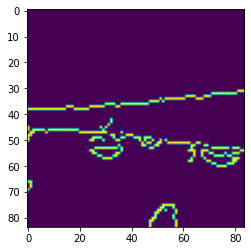

min 52
max 75
contour.shape (40, 1, 2)
transposed.shpae (1, 40, 2)
min 0
max 66
min 67
max 55
contour.shape (26, 1, 2)
transposed.shpae (1, 26, 2)
min 79
max 53
contour.shape (46, 1, 2)
transposed.shpae (1, 46, 2)
min 71
max 53
min 34
max 53
contour.shape (23, 1, 2)
transposed.shpae (1, 23, 2)
min 68
max 52
min 35
max 52
contour.shape (25, 1, 2)
transposed.shpae (1, 25, 2)
min 44
max 51
min 53
max 50
min 51
max 50
min 45
max 50
contour.shape (6, 1, 2)
transposed.shpae (1, 6, 2)
min 25
max 49
min 32
max 48
contour.shape (36, 1, 2)
transposed.shpae (1, 36, 2)
min 36
max 47
min 32
max 42
min 81
max 31
mask shape (84, 84, 3)
mask_color (0.0, 0.0, 0.0)


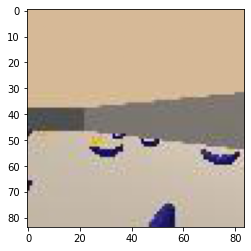

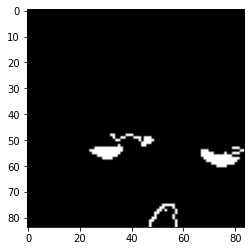

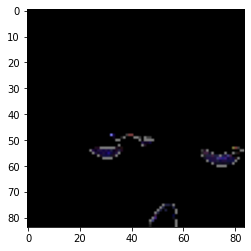

In [203]:
import numpy as np
import cv2

# Parameters
blur = 21
# canny_low = 15
# canny_high = 150
canny_low = 15
canny_high = 300

# min_area = 0.0005
# max_area = 0.95
min_area = 0.0005
max_area = 60

dilate_iter = 10
erode_iter = 10
mask_color = (0.0,0.0,0.0)

image = (np.squeeze(state) * 255).astype('uint8')

print('image.shape', image.shape)
print('image type', type(image))

# cv2.imshow("", image.astype('float32'))

# cv2.imshow("", image.astype('uint8') * 255)

# Convert image to grayscale        
# image_gray = cv2.cvtColor(image.astype('float32'), cv2.COLOR_BGR2GRAY)
# print(image)
#image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#image_gray = image
#print('image_grey.shape', image_gray.shape)

#plt.imshow(image_gray)
#plt.show()

# Apply Canny Edge Dection
edges = cv2.Canny(image, canny_low, canny_high)


#edges = cv2.dilate(edges, None)
#edges = cv2.erode(edges, None)
print('edges.shape', edges.shape)
plt.imshow(edges)
plt.show()

# get the contours and their areas
contour_info = [(c, cv2.contourArea(c),) for c in cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)[0]]

# Get the area of the image as a comparison
# image_area = frame.shape[0] * frame.shape[1]  
image_area = image.shape[0] * image.shape[1]
      
# calculate max and min areas in terms of pixels
max_area = max_area * image_area
min_area = min_area * image_area

# Set up mask with a matrix of 0's
mask = np.zeros(image.shape, dtype = np.uint8)

# Go through and find relevant contours and apply to mask
for contour in contour_info:
    #print(contour[1])
    #print(contour[0][0].shape)
    #print('min', min(np.squeeze(contour[0])[:,1]))
    print('min', min(contour[0][0][:,0]))
    print('max', max(contour[0][0][:,1]))
        
    # print('max', max(np.squeeze(contour[0])[:,1]))

    # Instead of worrying about all the smaller contours, if the area is smaller than the min, the loop will break
    if contour[1] > min_area and contour[1] < max_area:
        if not (np.min(contour[0][:,0][:,0]) == 0 and np.min(contour[0][:,0][:,0]) == 83):
            # Add contour to mask
            ignore_mask_color = (255,)*3
            print('contour.shape', contour[0].shape)
            print('transposed.shpae', np.transpose(contour[0], (1,0,2)).shape)
            #mask = cv2.fillPoly(mask, contour[0], ignore_mask_color)
            #mask = cv2.fillPoly(mask, np.transpose(contour[0], (1,0,2)), (255,255,255))
            mask = cv2.drawContours(mask, np.transpose(contour[0], (1,0,2)), -1, (255, 255, 255), thickness=-1)


            #mask = cv2.fillConvexPoly(mask, contour[0], (255))
# rect = np.array([[[20,20],[20, 60], [40,60], [40, 20]]])
# print('rect.shape', rect.shape)
# mask = cv2.fillPoly(mask, rect, (255,255,255))
        
# use dilate, erode, and blur to smooth out the mask
#mask = cv2.dilate(mask, None, iterations=mask_dilate_iter)
#mask = cv2.erode(mask, None, iterations=mask_erode_iter)
#mask = cv2.GaussianBlur(mask, (blur, blur), 0)

 # Ensures data types match up
mask = mask.astype('float32') / 255.0           
image = image.astype('float32') / 255.0

print('mask shape', mask.shape)
print('mask_color', mask_color)

# Blend the image and the mask
# masked = (mask * image) + ((1-mask) * mask_color)
plt.imshow(image)
plt.show()

masked = cv2.bitwise_and(image, mask)

# masked = (mask * image)

# masked = (masked * 255).astype('uint8')
# cv2.imshow("Foreground", masked)
plt.imshow(mask)
plt.show()

plt.imshow(masked)
plt.show()


In [150]:
print('min', np.min(contour[0][:,0][:,0]))
print('max', np.max(contour[0][:,0][:,0]))

contour[0][:,0][:,0]

min 0
max 83


array([81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65,
       64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48,
       47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31,
       30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14,
       13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 82], dtype=int32)

States look like:


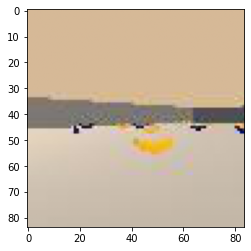

States have shape: (1, 84, 84, 3)


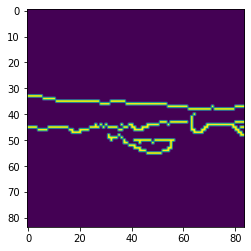

7.5
add to mask
[[[31 48]]

 [[31 49]]

 [[32 50]]

 [[33 49]]

 [[34 49]]

 [[35 48]]

 [[36 49]]

 [[37 50]]

 [[37 51]]

 [[38 51]]

 [[39 52]]

 [[40 52]]

 [[41 53]]

 [[42 53]]

 [[43 54]]

 [[44 54]]

 [[45 54]]

 [[46 55]]

 [[47 55]]

 [[48 55]]

 [[49 55]]

 [[50 55]]

 [[51 55]]

 [[52 54]]

 [[53 54]]

 [[54 54]]

 [[55 53]]

 [[55 52]]

 [[55 51]]

 [[56 50]]

 [[55 50]]

 [[54 50]]

 [[53 50]]

 [[52 50]]

 [[51 50]]

 [[50 50]]

 [[49 50]]

 [[48 51]]

 [[47 50]]

 [[46 50]]

 [[45 50]]

 [[44 50]]

 [[43 50]]

 [[42 50]]

 [[41 50]]

 [[42 50]]

 [[43 51]]

 [[44 50]]

 [[45 50]]

 [[46 50]]

 [[47 50]]

 [[48 51]]

 [[49 50]]

 [[50 50]]

 [[51 50]]

 [[52 50]]

 [[53 50]]

 [[54 50]]

 [[55 51]]

 [[55 52]]

 [[54 53]]

 [[53 54]]

 [[52 54]]

 [[51 55]]

 [[50 55]]

 [[49 55]]

 [[48 55]]

 [[47 55]]

 [[46 55]]

 [[45 54]]

 [[44 54]]

 [[43 53]]

 [[42 53]]

 [[41 52]]

 [[40 52]]

 [[39 52]]

 [[38 51]]

 [[37 50]]

 [[36 49]]

 [[35 48]]

 [[34 49]]

 [[33 49]]



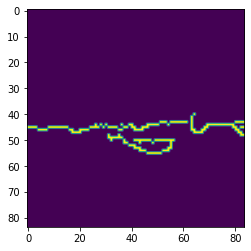

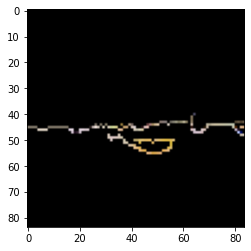

In [50]:
import numpy as np
import cv2

# examine the state space 
action = np.random.randint(action_size)        # select an action
env_info = env.step(action)[brain_name]
state = env_info.visual_observations[0]
print('States look like:')
plt.imshow(np.squeeze(state))
plt.show()
state_size = state.shape
print('States have shape:', state.shape)

image = (np.squeeze(state) * 255).astype('uint8')

g_blurred = cv2.GaussianBlur(image, (5, 5), 0)
#blurred_float = g_blurred.astype(np.float32) / 255.0
#edgeDetector = cv2.ximgproc.createStructuredEdgeDetection("model.yml")
#edges = edgeDetector.detectEdges(blurred_float) * 255.0
canny_low = 15
canny_high = 300
min_area = 1
max_area = 30

edges = cv2.Canny(g_blurred, canny_low, canny_high)

#cv2.imwrite('edge-raw.jpg', edges)
plt.imshow(edges)
plt.show()

def findSignificantContour(edgeImg):
    image, contours, hierarchy = cv2.findContours(
        edgeImg,
        cv2.RETR_TREE,
        cv2.CHAIN_APPROX_SIMPLE
    )
        # Find level 1 contours
    level1Meta = []
    for contourIndex, tupl in enumerate(hierarchy[0]):
        # Filter the ones without parent
        if tupl[3] == -1:
            tupl = np.insert(tupl.copy(), 0, [contourIndex])
            level1Meta.append(tupl)
# From among them, find the contours with large surface area.
    contoursWithArea = []
    for tupl in level1Meta:
        contourIndex = tupl[0]
        contour = contours[contourIndex]
        area = cv2.contourArea(contour)
        contoursWithArea.append([contour, area, contourIndex])
    contoursWithArea.sort(key=lambda meta: meta[1], reverse=True)
    largestContour = contoursWithArea[0][0]
    return largestContour

#contour = findSignificantContour(edges)
# Draw the contour on the original image
# contourImg = np.copy(src)
# cv2.drawContours(contourImg, [contour], 0, (0, 255, 0), 2, cv2.LINE_AA, maxLevel=1)
#print(contour)
#plt.imshow(edges)
#plt.show()

# cv2.imwrite('contour.jpg', contourImg)
# image_display('contour.jpg')
contour_info = [(c, cv2.contourArea(c),) for c in cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)[0]]
mask = np.zeros_like(edges)
#cv2.fillPoly(mask, [contour], 255)

for contour in contour_info:
    print(contour[1])
    # Instead of worrying about all the smaller contours, if the area is smaller than the min, the loop will break
    if contour[1] > min_area and contour[1] < max_area:
        # Add contour to mask
        # mask = cv2.fillPoly(mask, contour[0], 255)
        print('add to mask')
        print(contour[0])

        mask = cv2.fillConvexPoly(mask, contour[0], (255))

plt.imshow(mask)
plt.show()

masked = cv2.bitwise_or(image,image,mask = mask)

#masked = (mask * image) + ((1-mask) * mask_color)
plt.imshow(masked)
plt.show()

In [9]:
state[0, 0, 0] * 255
print(np.squeeze(state).shape[:2])

(84, 84)


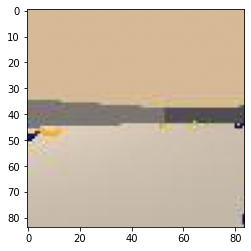

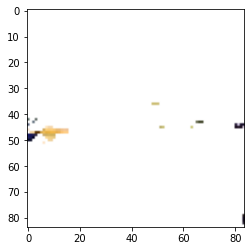

In [392]:
import cv2
# lower = np.array([200,170,135])/255  #-- Lower range --
# upper = np.array([225,200,180])/255  #-- Upper range --
action = np.random.randint(action_size)        # select an action
env_info = env.step(action)[brain_name]
state = np.copy(env_info.visual_observations[0])
img = np.squeeze(state)
# mask = cv2.inRange(img, lower, upper)
# res = cv2.bitwise_and(img, img, mask= mask)  #-- Contains pixels having the gray color--
# res = cv2.bitwise_not(img, img, mask= mask)  #-- Contains pixels having the gray color--

plt.imshow(np.squeeze(state))
plt.show()

accumMask = np.zeros(img.shape[:2], dtype="uint8")

# define the list of color boundaries
# [  211.,   201.,   174.]
# [  218.,   210.,   197.]
#[  221.,   204.,   186.]
#[  218.,   210.,   197.]
#[  230.,   221.,   190.]
# [  223.,   214.,   175.],
# [  225.,   207.,   185.]
#[  220.,   199.,   196.],
#[  228.,   219.,   204.]
#[  231.,   218.,   201.]
#[  213.,   200.,   183.]
#[  211.,   198.,   181.]
#[  236.,   228.,   191.]
#[  224.,   210.,   163.],
#[  208.,   192.,   192.]
#[  207.,   193.,   182.],
#[  228,   219,   210],
#[  225,   215,   242]
#[  225,   215,   242],
#        [  236,   226,   235]
#[  236,   226,   235]
#[  241,   236,   216]
#[  206,   189,   182]
#[  201,   192,   183]
#[  210,   201,   142]
#[   95,    89,    63]
#[[   86,    73,    93],
#        [   82,    79,    72],
#    [[   96,    76,    69],
#       [[   87,    69,    91],
#       [[   83,    73,   100],
#        [   84,    64,    66],
#        [   76,    55,    60],
#        [   82,    64,    64]],

#        [   79,    65,    82],
#        [   82,    67,    88],
#[   85,    71,    45]
#[   69,    65,    79]
#[   98,    88,    86]
# [[   91,    95,    81],
#       [[   79,    98,    78],
 #       [   64,    83,    63],

#       [[    0,     5,     9],
#        [   76,    78,   103],
#        [   77,    76,   107],
#        [   77,    76,   108],
#        [   77,    76,   110]],
#[  192,   176,   187]
#[  191,   179,   181]
#  [  189,   178,   192],
# [[  186,   170,   196],
#         [  187,   173,   196],
#         [  186,   174,   194],
#         [  184,   176,   191],
#         [  183,   178,   185]],
#[  104,   104,   102],
#[  109,   103,   117],
#        [  103,    94,   111],
#[   95,    76,    44],
#        [   99,    75,    41]
#[  102,    73,    39]
#  [  104,    75,    45],
#        [  101,    75,    50],
#[  109,   109,   107]
#[  169,   157,   141]
#[  182,   176,   188]
#[  168,   169,   153],
#[  167,   168,   154]
#[[   97,    81,    30],
#        [   97,    81,    29],
#        [   97,    82,    27]
#  [  204,   169,   201],
#        [  207,   166,   208],
#  [  185,   163,   184]
boundaries = [
    ([95,    70,    27],[105,82,50]),
    ([100,83,70],[109,109,117]),
    ([205,197,84],[205,197,84]),
    ([199, 192, 184], [199, 192, 184]),
    ([166, 150, 125], [230, 200, 180]),
    ([110, 90, 60], [160, 160, 160]),
    ([210, 201, 171], [241, 246, 242]),
    ([180,163,140],[236,228,210]),
    ([47,55,45], [98,98, 110])
   # ([40, 30, 50], [140, 120, 130])
]

# loop over the boundaries
for (lower, upper) in boundaries:
    # create NumPy arrays from the boundaries
    lower = np.array(lower, dtype="uint8")/255
    upper = np.array(upper, dtype="uint8")/255

    # find the colors within the specified boundaries
    mask = cv2.inRange(img, lower, upper)

    # merge the mask into the accumulated masks
    accumMask = cv2.bitwise_or(accumMask, mask)

res = cv2.bitwise_not(img, img, mask=accumMask)  #-- Contains pixels having the gray color--

#accumMask = cv2.bitwise_not(accumMask)
res[res < 0] = 255 

plt.imshow(res)
plt.show()



In [383]:
(res[50:55,70:75] * 255).astype('int')

array([[[65025, 65025, 65025],
        [65025, 65025, 65025],
        [65025, 65025, 65025],
        [  185,   163,   184],
        [65025, 65025, 65025]],

       [[65025, 65025, 65025],
        [65025, 65025, 65025],
        [65025, 65025, 65025],
        [65025, 65025, 65025],
        [65025, 65025, 65025]],

       [[65025, 65025, 65025],
        [65025, 65025, 65025],
        [65025, 65025, 65025],
        [65025, 65025, 65025],
        [65025, 65025, 65025]],

       [[65025, 65025, 65025],
        [65025, 65025, 65025],
        [65025, 65025, 65025],
        [65025, 65025, 65025],
        [65025, 65025, 65025]],

       [[65025, 65025, 65025],
        [65025, 65025, 65025],
        [65025, 65025, 65025],
        [  217,   179,   108],
        [  212,   178,   107]]])

hsv shape (84, 84, 3)


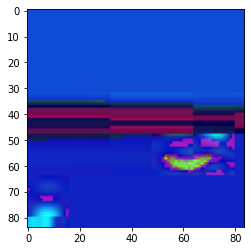

show blue portion


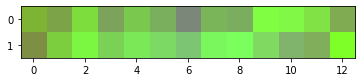

blue_int.shape (2, 13, 3)
blue_reshape.shape (26, 3)
unique_reshape.shape (26, 3)


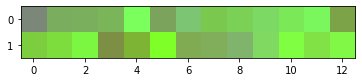

starting mask
masked before anything done should be same as hsv


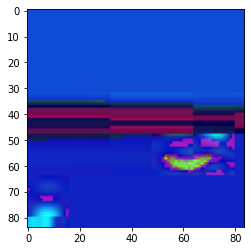

[[[ 16  75 214]
  [ 16  75 214]
  [ 16  75 214]
  ...
  [ 16  75 214]
  [ 16  75 214]
  [ 16  75 214]]

 [[ 16  75 214]
  [ 16  75 214]
  [ 16  75 214]
  ...
  [ 16  75 214]
  [ 16  75 214]
  [ 16  75 214]]

 [[ 16  75 214]
  [ 16  75 214]
  [ 16  75 214]
  ...
  [ 16  75 214]
  [ 16  75 214]
  [ 16  75 214]]

 ...

 [[ 18 198 255]
  [ 19 212 255]
  [ 21 226 254]
  ...
  [ 16  34 193]
  [ 16  34 193]
  [ 16  34 193]]

 [[ 18 199 255]
  [ 19 213 255]
  [ 20 225 253]
  ...
  [ 16  34 193]
  [ 16  34 193]
  [ 16  34 193]]

 [[ 18 200 255]
  [ 19 214 255]
  [ 20 226 252]
  ...
  [ 16  34 193]
  [ 16  34 193]
  [ 16  34 193]]]
number of boundaries 26


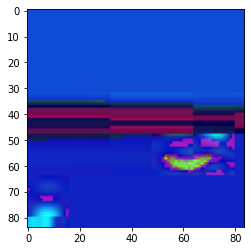

masked


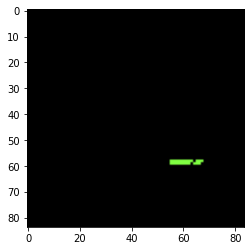

show edges


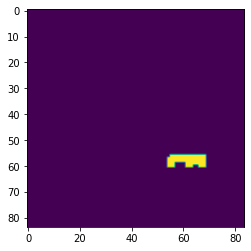

number of contours 1
[[[55 56]]

 [[54 57]]

 [[54 60]]

 [[56 60]]

 [[56 59]]

 [[57 58]]

 [[60 58]]

 [[61 59]]

 [[61 60]]

 [[63 60]]

 [[64 59]]

 [[65 59]]

 [[66 60]]

 [[68 60]]

 [[68 56]]]


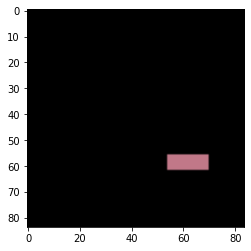

In [293]:
import cv2
import random

action_size = brain.vector_action_space_size
#env_info = env.reset(train_mode=True)[brain_name]

# lower = np.array([200,170,135])/255  #-- Lower range --
# upper = np.array([225,200,180])/255  #-- Upper range --
action = np.random.randint(action_size)        # select an action
#env_info = env.step(action)[brain_name]
state = np.copy(env_info.visual_observations[0])
img = np.squeeze(state)
img = (img * 255).astype('uint8')

hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#hsv = img
print('hsv shape', hsv.shape)


plt.imshow(hsv)
plt.show()

# mask = cv2.inRange(img, lower, upper)
# res = cv2.bitwise_and(img, img, mask= mask)  #-- Contains pixels having the gray color--
# res = cv2.bitwise_not(img, img, mask= mask)  #-- Contains pixels having the gray color--
# img = img[60:75,5:54,:]
#blue = img[65:70,11:48,:] # mac

blue = hsv[58:60,55:68,:]
#blue = hsv[56:62,53:71,:]


#blue_int = (blue * 255).astype('int')
print('show blue portion')
blue_int = blue
plt.imshow(blue_int)
plt.show()

#print(img_int)
print('blue_int.shape',blue_int.shape)

blue_reshape = blue_int.reshape(blue_int.shape[0] * blue_int.shape[1], blue_int.shape[2])
print('blue_reshape.shape',blue_reshape.shape)
#blue_reshape.sort(axis=0)
#print('img_reshape\n', img_reshape)
unique_reshape = np.unique(blue_reshape, axis=0)
print('unique_reshape.shape',unique_reshape.shape)
# print (unique_reshape)
#plt.imshow(unique_reshape.reshape(23,4,3))

#plt.imshow(unique_reshape.reshape(5,5,3))
plt.imshow(unique_reshape.reshape(2,13,3))
#plt.imshow(unique_reshape.reshape(6,18,3))

plt.show()

# boundaries = [((c - 1).tolist(),(c + 1).tolist()) for c in unique_reshape]
boundaries = [(c - 1,c + 1) for c in unique_reshape]

# pr1int(boundaries)


#unique = np.unique(img_int, axis=1)
#print('unique.shape',unique.shape)
#unique.sort()
#print('unique')


#print(state.shape)
#plt.imshow(unique)
#plt.show()

accumMask = np.zeros(hsv.shape[:2], dtype="uint8")
#accumMask = np.zeros(blue_int.shape[:2], dtype="uint8")

# define the list of color boundaries
# boundaries = [
 #    ([30, 10, 60], [60, 100, 140]),
 #    ([240, 175, 0], [255, 255, 120]),
 #   ([245, 245, 245], [255, 255, 255])

# ]

# loop over the boundaries
print('starting mask')
#plt.imshow(accumMask)
#plt.show()
   
masked = np.copy(hsv)

print('masked before anything done should be same as hsv')
plt.imshow(masked)
plt.show()
print(masked)

masks = []

for (lower, upper) in boundaries:
    # create NumPy arrays from the boundaries
    #lower = np.array(lower, dtype="uint8")/255
    #upper = np.array(upper, dtype="uint8")/255
    #lower = np.array(lower, dtype="uint8")
    #upper = np.array(upper, dtype="uint8")
    
    #print(lower, upper)

    # find the colors within the specified boundaries
    mask = cv2.inRange(masked, lower, upper)
    #print(mask.sum())
    masks.append(mask)
    
    
    #print('mask sum ', np.sum(mask))

    # merge the mask into the accumulated masks
    accumMask = cv2.bitwise_or(accumMask, mask)
    #print('masked.shape', masked.shape)
    #masked = cv2.bitwise_or(masked, masked, mask=mask) 
    #accumMask = accumMask + mask
    #plt.imshow(accumMask)
    #plt.show()
    
    #masked = cv2.bitwise_or(masked, mask)


#print('accumMask')
#plt.imshow(accumMask)
#plt.show()
#print(accumMask.shape)

print('number of boundaries', len(boundaries))
#res = cv2.bitwise_or(hsv, hsv, mask=accumMask) 
#accumMask = cv2.bitwise_not(accumMask)
masked = cv2.bitwise_or(hsv, hsv, mask=accumMask) 

#masked[masked != 0] = 255 
#print(masked != [255, 255, 255])
#mask[:,:,0masked[:,:,0] != 0]

plt.imshow(hsv)
plt.show()

masked = np.where(masked != [0, 0, 0], [128, 255,  66], [0, 0, 0])
#print((res[45:55,70:80]) * 255)
print('masked')
plt.imshow(masked)
plt.show()

#blur = cv2.blur(masked,(5,5))
#plt.imshow(blur)
#plt.show()
canny_low = 15
canny_high = 300

edges = cv2.Canny(masked.astype('uint8'), canny_low, canny_high)
edges = cv2.dilate(edges, None)
print('show edges')
plt.imshow(edges)
plt.show()

contours,_ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print('number of contours', len(contours))
    
contours_poly = [None]*len(contours)
boundRect = [None]*len(contours)
for i, c in enumerate(contours):
    print(c)
    contours_poly[i] = cv2.approxPolyDP(c, 3, True)
    boundRect[i] = cv2.boundingRect(contours_poly[i])

drawing = np.zeros((edges.shape[0], edges.shape[1], 3), dtype=np.uint8)
    
for i in range(len(contours)):
    color = (random.randint(0,256), random.randint(0,256), random.randint(0,256))
    cv2.drawContours(drawing, contours_poly, i, color)
    cv2.rectangle(drawing, (int(boundRect[i][0]), int(boundRect[i][1])), \
      (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, -1)

plt.imshow(drawing)
plt.show()
    

#contour_info = [(c, cv2.contourArea(c),) for c in cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)[0]]
#contour_info = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

mask = np.zeros_like(edges)
#cv2.fillPoly(mask, [contour], 255)

min_area = 0.0005
max_area = 60


#for contour in contour_info:
#    print(len(contour))
#    index = len(contour) - 1
#    print(contour[index])
    # Instead of worrying about all the smaller contours, if the area is smaller than the min, the loop will break
    #if contour[index] > min_area and contour[index] < max_area:
    #    # Add contour to mask
    #    # mask = cv2.fillPoly(mask, contour[0], 255)
    #    print('add to mask')
    #    print(contour[0])

#    mask = cv2.fillConvexPoly(mask, contour[0], (255))

#plt.imshow(mask)
#plt.show()



#nts = cv2.findContours(masked, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#cnts = cnts[0] if len(cnts) == 2 else cnts[1]

#rect = cv2.minAreaRect(cnts[0])
#box = cv2.boxPoints(rect)
#box = np.int0(box)
#cv2.drawContours(image,[box],0,(36,255,12),4)
#cv2.fillPoly(mask, [box], (255,255,255))

# Find corners
#mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
#corners = cv2.goodFeaturesToTrack(mask,4,.8,100)
#offset = 25
#for corner in corners:
#    x,y = corner.ravel()
#    cv2.circle(image,(x,y),5,(36,255,12),-1)
#    x, y = int(x), int(y)
#    cv2.rectangle(image, (x - offset, y - offset), (x + offset, y + offset), (36,255,12), 3)
#    print("({}, {})".format(x,y))


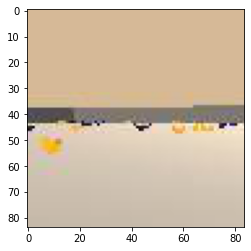

hsv shape (84, 84, 3)
len boundaries 1
sum mask 765
len boundaries 1
sum mask 15045


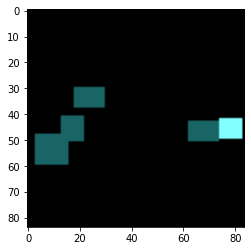

In [372]:
import json

def create_colors_from_coords(image, coord):
    blue = image[coord[0][0]:coord[0][1],coord[1][0]:coord[1][1],:]
    #blue = hsv[56:62,53:71,:]
    blue = blue
    plt.imshow(blue)
    plt.show()
    #print('blue.shape',blue.shape)
    blue_reshape = blue.reshape(blue.shape[0] * blue.shape[1], blue.shape[2])
    return blue_reshape

def save_colors(colors, name):
    d = [c.tolist() for c in colors]
    with open(f'{name}.json', 'w') as fp:
        json.dump(d, fp)

def load_colors(name):
    with open(f'{name}.json') as fp:
        data = json.load(fp)
    return [np.array(c) for c in data]

def create_color_boundaries(colors):
    boundaries = [(c - 3,c + 3) for c in colors]
    return boundaries

def draw_bounding_rectangles(image, color):
    canny_low = 15
    canny_high = 300

    edges = cv2.Canny(image.astype('uint8'), canny_low, canny_high)
    edges = cv2.dilate(edges, None)
    #print('show edges')
    #plt.imshow(edges)
    #plt.show()

    contours,_ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #print('number of contours', len(contours))

    contours_poly = [None]*len(contours)
    boundRect = [None]*len(contours)
    for i, c in enumerate(contours):
        #print(c)
        contours_poly[i] = cv2.approxPolyDP(c, 3, True)
        boundRect[i] = cv2.boundingRect(contours_poly[i])

    drawing = np.zeros((edges.shape[0], edges.shape[1], 3), dtype=np.uint8)

    for i in range(len(contours)):
        cv2.drawContours(drawing, contours_poly, i, color)
        cv2.rectangle(drawing, (int(boundRect[i][0]), int(boundRect[i][1])), \
          (int(boundRect[i][0]+boundRect[i][2]) + 1, int(boundRect[i][1]+boundRect[i][3]) + 2), color, -1)
    return drawing

def mask_by_color(image, boundaries):
    accumMask = np.zeros(image.shape[:2], dtype="uint8")
    #print('len boundaries', len(boundaries))
    for (lower, upper) in boundaries:
        # find the colors within the specified boundaries
        mask = cv2.inRange(image, lower, upper)
        #print('sum mask', np.sum(mask))
        # merge the mask into the accumulated masks    
        accumMask = cv2.bitwise_or(accumMask, mask)

    return cv2.bitwise_or(image, image, mask=accumMask) 

def rectangles_color(image, boundaries, rectangle_color):
    masked = mask_by_color(image, boundaries)
    return draw_bounding_rectangles(masked, rectangle_color)




action = np.random.randint(action_size)        # select an action
env_info = env.step(action)[brain_name]
state = np.copy(env_info.visual_observations[0])
img = np.squeeze(state)
img = (img * 255).astype('uint8')
plt.imshow(img)
plt.show()

hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#hsv = img
print('hsv shape', hsv.shape)

#plt.imshow(hsv)
#plt.show()


#masked = np.copy(hsv)

#blue_colors = create_colors_from_coords(hsv, ((58,60),(55,68)))
#save_colors(blue_colors, 'blue-bananas')

blue_colors = load_colors('blue-bananas')
blue_color = (130, 255,  255)
blue_boundaries = [(np.array([100,150,0],np.uint8), np.array([140,255,255],np.uint8))]
blue_rectangles = rectangles_color(hsv, blue_boundaries, blue_color)

#print('show blue_masked')
#plt.imshow(blue_rectangles)
#plt.show()


#boundaries = create_color_boundaries(blue_colors)

yellow_color = (25, 100,  100)
# yellow 
yellow_boundaries = [(np.array([20, 100, 100]), np.array([30, 255, 255]))]
yellow_rectangles = rectangles_color(hsv, yellow_boundaries, yellow_color)

#yellow_masked = mask_by_color(masked, boundaries)
#yellow_color = (25, 200,  200)

#yellow_drawing = draw_bounding_rectangles(masked, yellow_color)

#for i in range(len(contours)):
#    cv2.drawContours(drawing, contours_poly, i, color)
#    cv2.rectangle(drawing, (int(boundRect[i][0]), int(boundRect[i][1])), \
#      (int(boundRect[i][0]+boundRect[i][2]) + 1, int(boundRect[i][1]+boundRect[i][3]) + 2), color, -1)

#print('show yellow_masked')
#plt.imshow(yellow_rectangles)
#plt.show()

combined = cv2.bitwise_or(blue_rectangles, yellow_rectangles) 
plt.imshow(combined)
plt.show()



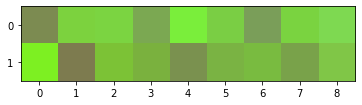

26


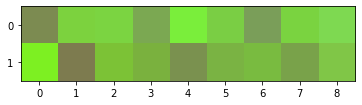

blue.shape (2, 9, 3)
18


AttributeError: module 'numpy' has no attribute 'concatinate'

In [331]:

blue = hsv[58:60, 56:65]
plt.imshow(blue)
plt.show()

blue_colors = load_colors('blue-bananas')
print(len(blue_colors))
new_colors = create_colors_from_coords(hsv, ((58,60),(56,65)))
print(len(new_colors))

new_set = np.concatenate(blue_colors, new_colors)



(84, 84, 3)


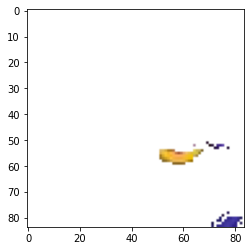

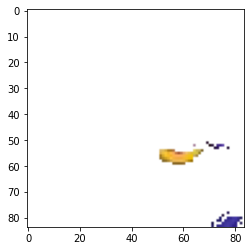

In [8]:
print(res.shape)
res[40:50, 60:65]*255
res2 = res.clip(min=0)
plt.imshow(res2)
plt.show()

res[res < 0] = 255 
plt.imshow(res)
plt.show()


In [8]:
action = np.random.randint(action_size)        # select an action
env_info = env.step(action)[brain_name]        # send the action to the environment
next_state = env_info.visual_observations[0]   # get the next state
next_state.shape

(1, 84, 84, 3)

In [8]:
next_x = next_state[0]

In [16]:
sample = np.array([x, next_x])
sample.shape
s = np.vstack([x for x in [state, next_state]])
s.shape

(2, 84, 84, 3)

In [19]:
import torch
import torch.nn as nn
conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=8, stride=4)
single_state = torch.squeeze(torch.from_numpy(state))
x = torch.transpose(single_state, 0, 2)
x = torch.unsqueeze(x, 0).float()
print(x.shape)
x = conv1(x.float())


torch.Size([1, 3, 84, 84])


In [25]:
x = env_info.visual_observations[0]

print(x.shape)
x = np.squeeze(x)
print(x.shape)
x = np.transpose(x, (2, 0, 1))
print(x.shape)


(1, 84, 84, 3)
(84, 84, 3)
(3, 84, 84)


In [11]:
state[0,0,0]

array([0.83921569, 0.7254902 , 0.59215686])

In [12]:
state[0,0,0,0]

0.8392156862745098

In [13]:
state[0,0,0,1]

0.7254901960784313

In [40]:
b = state[0,45:80,40:65]

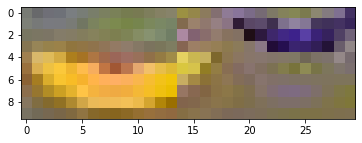

In [9]:
bananas = state[0,50:60,50:80]
plt.imshow(np.squeeze(bananas))
plt.show()

(10, 30, 3)
blue shape (2, 2, 3)
[[[ 65.  40. 132.]
  [ 61.  34. 139.]]

 [[ 37.  15.  80.]
  [ 58.  36. 111.]]]


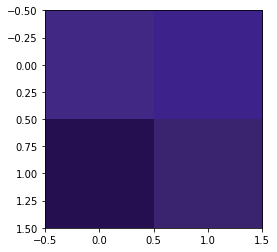

closeness to yellow 0.295078919138595
closeness to yellow (mse) 0.4488145585031398
close to blue 0.5166282680460261
close to blue (mse) 0.006048955529924388
[[[0.25490196 0.15686275 0.51764706]
  [0.23921569 0.13333333 0.54509804]]

 [[0.14509804 0.05882353 0.31372549]
  [0.22745098 0.14117647 0.43529412]]]
[[[ 65.  40. 132.]
  [ 61.  34. 139.]]

 [[ 37.  15.  80.]
  [ 58.  36. 111.]]]
['0x41', '0x28', '0x84', '0x3d', '0x22', '0x8b', '0x25', '0xf', '0x50', '0x3a', '0x24', '0x6f']


In [13]:
ycolor = np.array([int('ff', 16),int('eb', 16), int('2a', 16)])/255
bcolor = np.array([int('41', 16),int('28', 16), int('84', 16)])/255

# bcolor = np.array([0,0,int('80', 16)])/255

print(bananas.shape)
blue = bananas[2:4, 23:25]
print('blue shape', blue.shape)
print(blue*255)
plt.imshow(np.squeeze(blue))
plt.show()
ycloseness = np.dot(blue,ycolor)/ np.linalg.norm(ycolor)
ycloseness2 = np.power(blue - ycolor, 2)

print('closeness to yellow', np.mean(ycloseness))
print('closeness to yellow (mse)', np.mean(ycloseness2))

bcloseness = np.dot(blue,bcolor)/ np.linalg.norm(bcolor)
bcloseness2 = np.power(blue - bcolor, 2)

print('close to blue', np.mean(bcloseness))
print('close to blue (mse)', np.mean(bcloseness2))
print(blue)
print(blue*255)
print([hex(int(v)) for v in (blue*255).flatten()])



In [80]:
print(blue.shape)
print(bcolor.shape)
bdiff = np.absolute(blue - bcolor)
print(bdiff.shape)
print(bdiff[0,0])
print(blue[0,0,0])
print(bcolor[0])
print(blue[0,0,0] - bcolor[0])


(6, 2, 3)
(3,)
(6, 2, 3)
[0.2627451  0.32941176 0.10588235]
0.5176470588235295
0.2549019607843137
0.26274509803921575


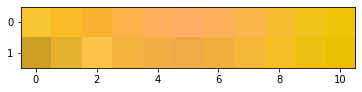

[[248. 196.  48.]
 [248. 188.  38.]
 [246. 178.  45.]
 [255. 180.  74.]
 [255. 176.  91.]
 [254. 175. 100.]
 [251. 176.  93.]
 [249. 182.  77.]
 [246. 189.  50.]
 [242. 194.  26.]
 [240. 196.   9.]]


IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

In [31]:
yellow = bananas[6:8, 3:14]
plt.imshow(np.squeeze(yellow))

plt.show()
print(yellow[0]*255)
print(yellow[0,:,0,0])

np.mean(yellow[:,:,1])
print(yellow.shape)
ycloseness = np.dot(yellow,ycolor)
print(closeness.shape)
print('closeness to yellow', np.mean(ycloseness))
bcloseness = np.dot(yellow,bcolor)
print('close to blue', np.mean(bcloseness))



In [22]:
print(yellow.shape)
closeness = np.dot(yellow,ycolor)
print(closeness.shape)
print(type(closeness))
print(len(closeness))
print(np.mean(closeness))
print(np.sum(closeness))
print(np.sum(closeness) / (7*12))
print(closeness)

(7, 12, 3)
(7, 12)
<class 'numpy.ndarray'>
7
66.5966386554622
5594.117647058824
66.5966386554622
[[55.88235294 51.17647059 51.37254902 50.58823529 51.17647059 52.74509804
  52.35294118 49.60784314 46.66666667 47.05882353 49.21568627 46.07843137]
 [75.09803922 58.82352941 55.09803922 57.25490196 51.96078431 50.39215686
  52.54901961 51.96078431 50.19607843 53.1372549  58.62745098 85.88235294]
 [88.43137255 82.35294118 86.66666667 82.15686275 60.78431373 48.62745098
  59.80392157 77.84313725 85.09803922 82.54901961 79.80392157 81.56862745]
 [87.05882353 85.49019608 83.1372549  85.29411765 84.50980392 84.11764706
  83.7254902  84.50980392 85.29411765 85.49019608 85.49019608 72.94117647]
 [71.37254902 79.60784314 88.43137255 82.94117647 80.98039216 80.19607843
  81.17647059 83.92156863 85.29411765 84.50980392 83.33333333 52.74509804]
 [50.58823529 60.98039216 73.52941176 82.35294118 83.1372549  83.92156863
  85.29411765 82.74509804 73.92156863 61.17647059 51.96078431 45.09803922]
 [43.7254

In [73]:
yellow[:,:,0].flatten() + yellow[:,:,0].flatten()

array([1.21568627, 1.12941176, 1.1372549 , 1.12156863, 1.12941176,
       1.15294118, 1.12156863, 1.04313725, 0.96470588, 0.95686275,
       0.98823529, 1.05098039, 1.6627451 , 1.35686275, 1.30196078,
       1.36470588, 1.25490196, 1.21568627, 1.23921569, 1.2       ,
       1.12941176, 1.16078431, 1.25490196, 1.79607843, 1.96862745,
       1.8745098 , 1.99215686, 1.92941176, 1.51372549, 1.2627451 ,
       1.46666667, 1.79607843, 1.89803922, 1.81176471, 1.74117647,
       1.70196078, 1.94509804, 1.94509804, 1.92941176, 2.        ,
       2.        , 1.99215686, 1.96862745, 1.95294118, 1.92941176,
       1.89803922, 1.88235294, 1.56078431, 1.6       , 1.78823529,
       2.        , 1.91372549, 1.89019608, 1.8745098 , 1.89019608,
       1.91372549, 1.92156863, 1.8745098 , 1.84313725, 1.18431373,
       1.1372549 , 1.36470588, 1.63921569, 1.83529412, 1.86666667,
       1.88235294, 1.90588235, 1.85098039, 1.6627451 , 1.39607843,
       1.20784314, 1.01960784, 0.94901961, 1.00392157, 1.12941

In [75]:
np.mean(yellow[:,:,1])

0.5795051353874884

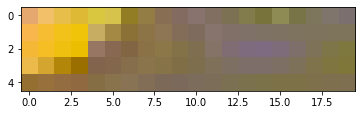

0.49317647058823544

In [98]:
blue = bananas[5:90, 10:50]
plt.imshow(np.squeeze(blue))
plt.show()
np.mean(blue[:,:,1])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [1]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.visual_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.visual_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

NameError: name 'env' is not defined

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
from lib.models import DuelingConvQNetwork, ConvQNetwork
#model = DuelingConvQNetwork(state_size, action_size, 0)
#model(state)

<class 'numpy.ndarray'>
21168


torch.Size([84, 84, 3])

In [27]:
x[0].transpose(0, 2).shape

torch.Size([3, 84, 84])

In [30]:
xp.shape

torch.Size([1, 3, 84, 84])

In [32]:
input_size = 3 * 84 * 84

In [33]:
xp_resized = xp.resize(xp.size(0), input_size)

/home/mark.melling/anaconda3/envs/drlnd/lib/python3.6/site-packages/torch/tensor.py:330: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [34]:
xp_resized.shape

torch.Size([1, 21168])

In [47]:
in_channels = 3
out_channels = 32
#conv1 = nn.Conv2d(in_channels, out_channels, filter_size, stride=4)
#conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=2)
conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=8, stride=4)
conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
in_features = 7*7*64
fc1_units = 64
fc1 = nn.Linear(in_features, fc1_units)

xp.shape

torch.Size([1, 3, 84, 84])

In [48]:
import torch.nn.functional as F
x = xp.float()
x = conv1(x)
x = F.relu(x)
x = conv2(F.relu(x))
x = conv3(F.relu(x))


x.shape
x = x.view(x.size(0), -1)
print('size of x', x.size(0))
x = F.relu(fc1(x))


size of x 1


In [56]:
state.shape

(1, 84, 84, 3)

In [64]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

x = torch.from_numpy(state[0]).float().to(device)
x.shape


torch.Size([84, 84, 3])

In [ ]:
import torch
import cv2

from lib.agents import AgentExperienceReplay, AgentPrioritizedExperienceReplay

from lib.dqn import dqn
from lib.models import DuelingConvQNetwork, ConvQNetwork

import matplotlib.pyplot as plt
%matplotlib inline

import json

def create_colors_from_coords(image, coord):
    blue = image[coord[0][0]:coord[0][1],coord[1][0]:coord[1][1],:]
    #blue = hsv[56:62,53:71,:]
    blue = blue
    plt.imshow(blue)
    plt.show()
    #print('blue.shape',blue.shape)
    blue_reshape = blue.reshape(blue.shape[0] * blue.shape[1], blue.shape[2])
    return blue_reshape

def save_colors(colors, name):
    d = [c.tolist() for c in colors]
    with open(f'{name}.json', 'w') as fp:
        json.dump(d, fp)

def load_colors(name):
    with open(f'{name}.json') as fp:
        data = json.load(fp)
    return [np.array(c) for c in data]

def create_color_boundaries(colors):
    boundaries = [(c - 3,c + 3) for c in colors]
    return boundaries

def draw_bounding_rectangles(image, color):
    canny_low = 15
    canny_high = 300

    edges = cv2.Canny(image.astype('uint8'), canny_low, canny_high)
    edges = cv2.dilate(edges, None)
    #print('show edges')
    #plt.imshow(edges)
    #plt.show()

    contours,_ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #print('number of contours', len(contours))

    contours_poly = [None]*len(contours)
    boundRect = [None]*len(contours)
    for i, c in enumerate(contours):
        #print(c)
        contours_poly[i] = cv2.approxPolyDP(c, 3, True)
        boundRect[i] = cv2.boundingRect(contours_poly[i])

    drawing = np.zeros((edges.shape[0], edges.shape[1], 3), dtype=np.uint8)

    for i in range(len(contours)):
        cv2.drawContours(drawing, contours_poly, i, color)
        cv2.rectangle(drawing, (int(boundRect[i][0]), int(boundRect[i][1])), \
          (int(boundRect[i][0]+boundRect[i][2]) + 1, int(boundRect[i][1]+boundRect[i][3]) + 2), color, -1)
    return drawing

def mask_by_color(image, boundaries):
    accumMask = np.zeros(image.shape[:2], dtype="uint8")
    #print('len boundaries', len(boundaries))
    for (lower, upper) in boundaries:
        # find the colors within the specified boundaries
        mask = cv2.inRange(image, lower, upper)
        #print('sum mask', np.sum(mask))
        # merge the mask into the accumulated masks    
        accumMask = cv2.bitwise_or(accumMask, mask)

    return cv2.bitwise_or(image, image, mask=accumMask) 

def rectangles_color(image, boundaries, rectangle_color):
    masked = mask_by_color(image, boundaries)
    return draw_bounding_rectangles(masked, rectangle_color)


def create_model(state_size, action_size, seed):
    return ConvQNetwork(state_size, action_size, seed, fc_units=[512])

def create_mask_extract_bananas(img):
    accumMask = np.zeros(img.shape[:2], dtype="uint8")

    # define the list of color boundaries
    boundaries = [
        ([30, 10, 60], [80, 100, 140]),
        ([240, 175, 0], [255, 255, 120])
    ]

    # loop over the boundaries
    for (lower, upper) in boundaries:
        # create NumPy arrays from the boundaries
        lower = np.array(lower, dtype="uint8")/255
        upper = np.array(upper, dtype="uint8")/255

        # find the colors within the specified boundaries
        mask = cv2.inRange(img, lower, upper)

        # merge the mask into the accumulated masks
        accumMask = cv2.bitwise_or(accumMask, mask)
    return accumMask

def create_mask_exclude_background(img):
    accumMask = np.zeros(img.shape[:2], dtype="uint8")

    # define the list of color boundaries
    # boundaries = [
    #     ([170, 150, 125], [230, 200, 180]),
    #     ([110, 90, 60], [160, 160, 160]),
    #     ([40, 30, 50], [140, 120, 130])
    # ]
    boundaries = [
    ([95,    70,    27],[105,82,50]),
    ([100,83,70],[109,109,117]),
    ([205,197,84],[205,197,84]),
    ([199, 192, 184], [199, 192, 184]),
    ([166, 150, 125], [230, 200, 180]),
    ([110, 90, 60], [160, 160, 160]),
    ([210, 201, 171], [241, 246, 242]),
    ([180,163,140],[236,228,210]),
    ([47,55,45], [98,98, 110])
   # ([40, 30, 50], [140, 120, 130])
    ]

    # loop over the boundaries
    for (lower, upper) in boundaries:
        # create NumPy arrays from the boundaries
        lower = np.array(lower, dtype="uint8")/255
        upper = np.array(upper, dtype="uint8")/255

        # find the colors within the specified boundaries
        mask = cv2.inRange(img, lower, upper)

        # merge the mask into the accumulated masks
        accumMask = cv2.bitwise_or(accumMask, mask)
    return accumMask

def process_image_old(img):
    #imageMask = create_mask_extract_bananas(img)
    imageMask = create_mask_exclude_background(img)
    
    res = cv2.bitwise_or(img, img, mask=imageMask) 
    #-- Contains pixels having the gray color--
    #res = cv2.bitwise_not(img, img, mask=imageMask)  
    
    res[res < 0] = 0 
    return res

def process_image(img):
    img = (img * 255).astype('uint8')
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    blue_color = (130, 255,  255)
    blue_boundaries = [(np.array([100,150,0],np.uint8), np.array([140,255,255],np.uint8))]
    blue_rectangles = rectangles_color(hsv, blue_boundaries, blue_color)

    yellow_color = (25, 100,  100)
    yellow_boundaries = [(np.array([20, 100, 100]), np.array([30, 255, 255]))]
    yellow_rectangles = rectangles_color(hsv, yellow_boundaries, yellow_color)

    combined = cv2.bitwise_or(blue_rectangles, yellow_rectangles) 
    return combined

def get_state(env_info):
    state = env_info.visual_observations[0] 
    # remove axis of length 1
    #state = np.squeeze(state)
    #state = np.transpose(state, (2, 0, 1))
    #print('get_state shape', state.shape)
    state[0] = process_image(state[0])
    #print('get_state shape', state.shape)
    #print('processed state', state)
    return state




# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = get_state(env_info)
# print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

agent = AgentExperienceReplay(state_size=state_size, 
                                action_size=action_size, 
                                seed=0, 
                                train_mode=True,
                                batch_size=32,
                                create_model=create_model
                               )


agent_name = 'pixel_conv'

agent.load_model(agent_name)
n_episodes = 500


scores = dqn(env, 
             brain_name, 
             agent,
             n_episodes=n_episodes,
             eps_end=0.1, 
             checkpoint=13,
             agent_name=agent_name,
             get_state=get_state,
             batched_state=True)

agent.save_model(agent_name)


Number of agents: 1
Number of actions: 4
States have length: 1
Episode 83	Average Score: 0.08